# Testing clustering with the Loureiro Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import re
import time
import math
from scripts.clustering_utils import select_past_timesteps

/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df = pd.read_csv("../../data/loureiro_45houses.csv")
n_houses = df.shape[1] - 1
df.Time = pd.to_datetime(df.Time)
df

,Time,Energy_1,Energy_2,Energy_9,Energy_11,Energy_15,Energy_16,Energy_17,Energy_29,Energy_30,...,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.114,0.164,0.072,0.055,0.011,0.006,...,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004,0.008
1,2022-05-05 12:15:00,0.070,0.018,0.024,0.190,0.135,0.058,0.060,0.002,0.006,...,0.053,0.004,0.048,0.078,0.053,0.055,0.063,0.010,0.003,0.056
2,2022-05-05 12:30:00,0.122,0.018,0.024,0.180,0.121,0.011,0.096,0.010,0.006,...,0.035,0.004,0.062,0.061,0.057,0.055,0.049,0.010,0.004,0.033
3,2022-05-05 12:45:00,0.132,0.018,0.024,0.167,0.138,0.010,0.064,0.004,0.006,...,0.082,0.004,0.056,0.125,0.034,0.055,0.097,0.010,0.004,0.062
4,2022-05-05 13:00:00,0.125,0.018,0.024,0.133,0.104,0.011,0.072,0.002,0.006,...,0.076,0.004,0.034,0.070,0.038,0.055,0.075,0.010,0.004,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2023-06-05 10:45:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38012,2023-06-05 11:00:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38013,2023-06-05 11:15:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
38014,2023-06-05 11:30:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028


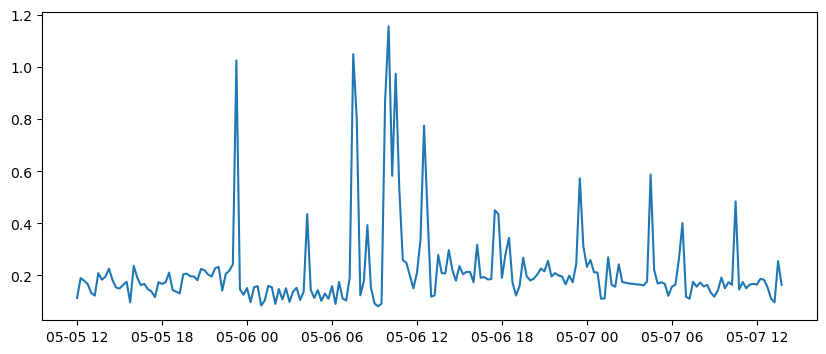

In [3]:
plt.figure(figsize=(10,4))
plt.plot(df.iloc[:200,0],df.iloc[:200,4])
plt.show()

In [4]:
undersample_data = df.loc[np.linspace(df.index.min(),df.index.max(),3000).astype(int)]
#undersample_time = df_index.loc[np.linspace(df_index.index.min(),df_index.index.max(),8784).astype(int)]
undersample_data = undersample_data.reset_index().drop('index',axis=1)
undersample_data

,Time,Energy_1,Energy_2,Energy_9,Energy_11,Energy_15,Energy_16,Energy_17,Energy_29,Energy_30,...,Energy_139,Energy_142,Energy_146,Energy_148,Energy_151,Energy_159,Energy_160,Energy_161,Energy_164,Energy_172
0,2022-05-05 12:00:00,0.068,0.018,0.024,0.114,0.164,0.072,0.055,0.011,0.006,...,0.083,0.084,0.068,0.060,0.042,0.055,0.069,0.010,0.004,0.008
1,2022-05-05 15:00:00,0.096,0.018,0.024,0.150,0.093,0.072,0.064,0.012,0.006,...,0.086,0.004,0.025,0.044,0.095,0.055,0.101,0.010,0.003,0.031
2,2022-05-05 18:15:00,0.036,0.018,0.024,0.174,0.080,0.074,0.086,0.137,0.006,...,0.060,0.004,0.082,0.040,0.021,0.055,0.109,0.010,0.004,0.042
3,2022-05-05 21:30:00,0.121,0.018,0.024,0.196,0.112,0.003,0.170,0.011,0.006,...,0.051,0.004,0.115,0.105,0.144,0.055,0.069,0.010,0.004,0.052
4,2022-05-06 00:30:00,0.082,0.018,0.024,0.155,0.043,0.003,0.038,0.013,0.006,...,0.054,0.004,0.072,0.054,0.074,0.055,0.093,0.010,0.004,0.033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,2023-06-04 23:00:00,0.169,0.107,0.099,0.175,0.147,0.003,0.137,0.007,0.072,...,0.081,0.004,0.050,0.020,0.073,0.158,0.076,0.011,0.003,0.047
2996,2023-06-05 02:00:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
2997,2023-06-05 05:15:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028
2998,2023-06-05 08:30:00,0.094,0.032,0.074,0.203,0.108,0.002,0.124,0.012,0.013,...,0.063,0.004,0.063,0.014,0.042,0.168,0.397,0.019,0.003,0.028


Text(0, 0.5, 'Temperature')

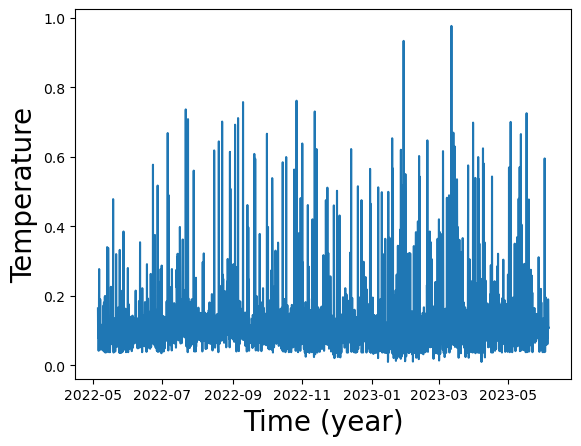

In [5]:
plt.plot(undersample_data.Time,undersample_data["Energy_15"])
plt.xlabel('Time (year)',fontsize=20)
plt.ylabel('Temperature',fontsize=20)

In [6]:
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
undersmpl = pd.DataFrame(scaler.fit_transform(undersample_data.drop('Time', axis=1)).reshape(3000,n_houses))

In [7]:
n_clusters = 16

In [8]:
from tqdm import tqdm
data_array = np.array(undersmpl.T.values)
cities_list = undersmpl.T.index.tolist()
inertia_list = []
cluster_list = []
model_list = []
for c in tqdm(range(2, n_clusters + 1)):
    model = TimeSeriesKMeans(n_clusters=c, metric="euclidean", max_iter=10, n_init=3, dtw_inertia=True)
    model.fit(data_array)
    model_list.append(model)
    inertia_list.append(model.inertia_)
    cluster_list.append(model.labels_)

100%|██████████| 15/15 [57:37<00:00, 230.52s/it]


Text(0, 0.5, 'Inertia')

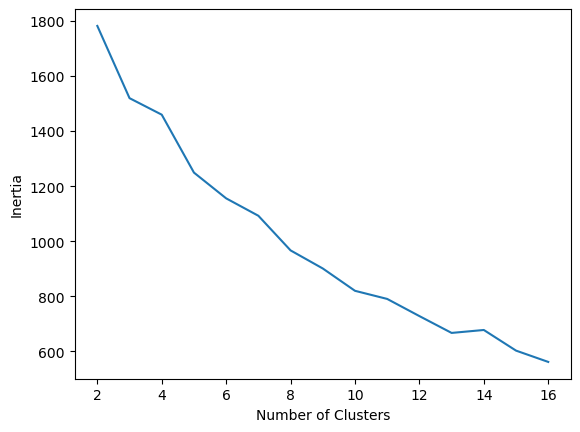

In [9]:
plt.plot(range(2, n_clusters +1), inertia_list)
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")

In [10]:
sourceFile = open("new_clusters_loureiro_euclidean.txt", 'w')

In [11]:
print("Cluster List\n", file=sourceFile)
print(cluster_list, file=sourceFile)
print("Inertia List\n", file=sourceFile)
print(inertia_list, file=sourceFile)
print("Model List\n", file=sourceFile)
print(model_list, file=sourceFile)

In [12]:
sourceFile.close()

In [20]:
cluster_list

[array([0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
        1]),
 array([1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 2, 2, 2,
        1, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2,
        2]),
 array([3, 3, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 1, 3, 1, 2, 3, 1, 2, 2, 2, 2,
        3, 3, 0, 3, 2, 2, 3, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 3, 3, 2, 2,
        3]),
 array([1, 0, 1, 2, 1, 0, 1, 0, 0, 0, 1, 0, 4, 0, 3, 0, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0]),
 array([2, 1, 2, 3, 2, 1, 2, 1, 0, 1, 2, 1, 5, 1, 4, 1, 1, 3, 1, 1, 1, 1,
        2, 2, 0, 2, 1, 1, 2, 1, 0, 2, 1, 3, 2, 3, 1, 2, 1, 2, 2, 2, 1, 1,
        1]),
 array([0, 0, 0, 1, 0, 4, 0, 4, 0, 0, 0, 4, 3, 0, 5, 4, 0, 3, 4, 4, 4, 0,
        0, 6, 0, 0, 4, 4, 0, 4, 0, 2, 0, 3, 0, 3, 4, 0, 4, 0, 0, 0, 4, 4,
        0]),
 array([0, 5, 0, 1, 0, 5, 0, 5, 5,

In [ ]:
# Executed with 1-hour intervals
#y = np.array([1, 2, 0, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0,
#       0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
#       0, 0, 0, 0, 0, 0, 0])

In [13]:
x = undersample_data['Time']

In [22]:
cluster_list[2]

array([3, 3, 3, 1, 3, 2, 3, 2, 3, 2, 3, 2, 1, 3, 1, 2, 3, 1, 2, 2, 2, 2,
       3, 3, 0, 3, 2, 2, 3, 2, 3, 3, 3, 1, 3, 1, 2, 3, 2, 3, 3, 3, 2, 2,
       3])

In [23]:
#y = np.array([5, 4, 0, 0, 1, 0, 4, 1, 0, 1, 3, 4, 7, 1, 4, 5, 1, 1, 6, 5, 5, 5, 4, 1, 6, 0, 1, 5, 0, 1, 4, 2, 1, 0, 1, 4, 5, 0, 6, 1])
y = cluster_list[2]
cities_list = undersmpl.T.index.tolist()

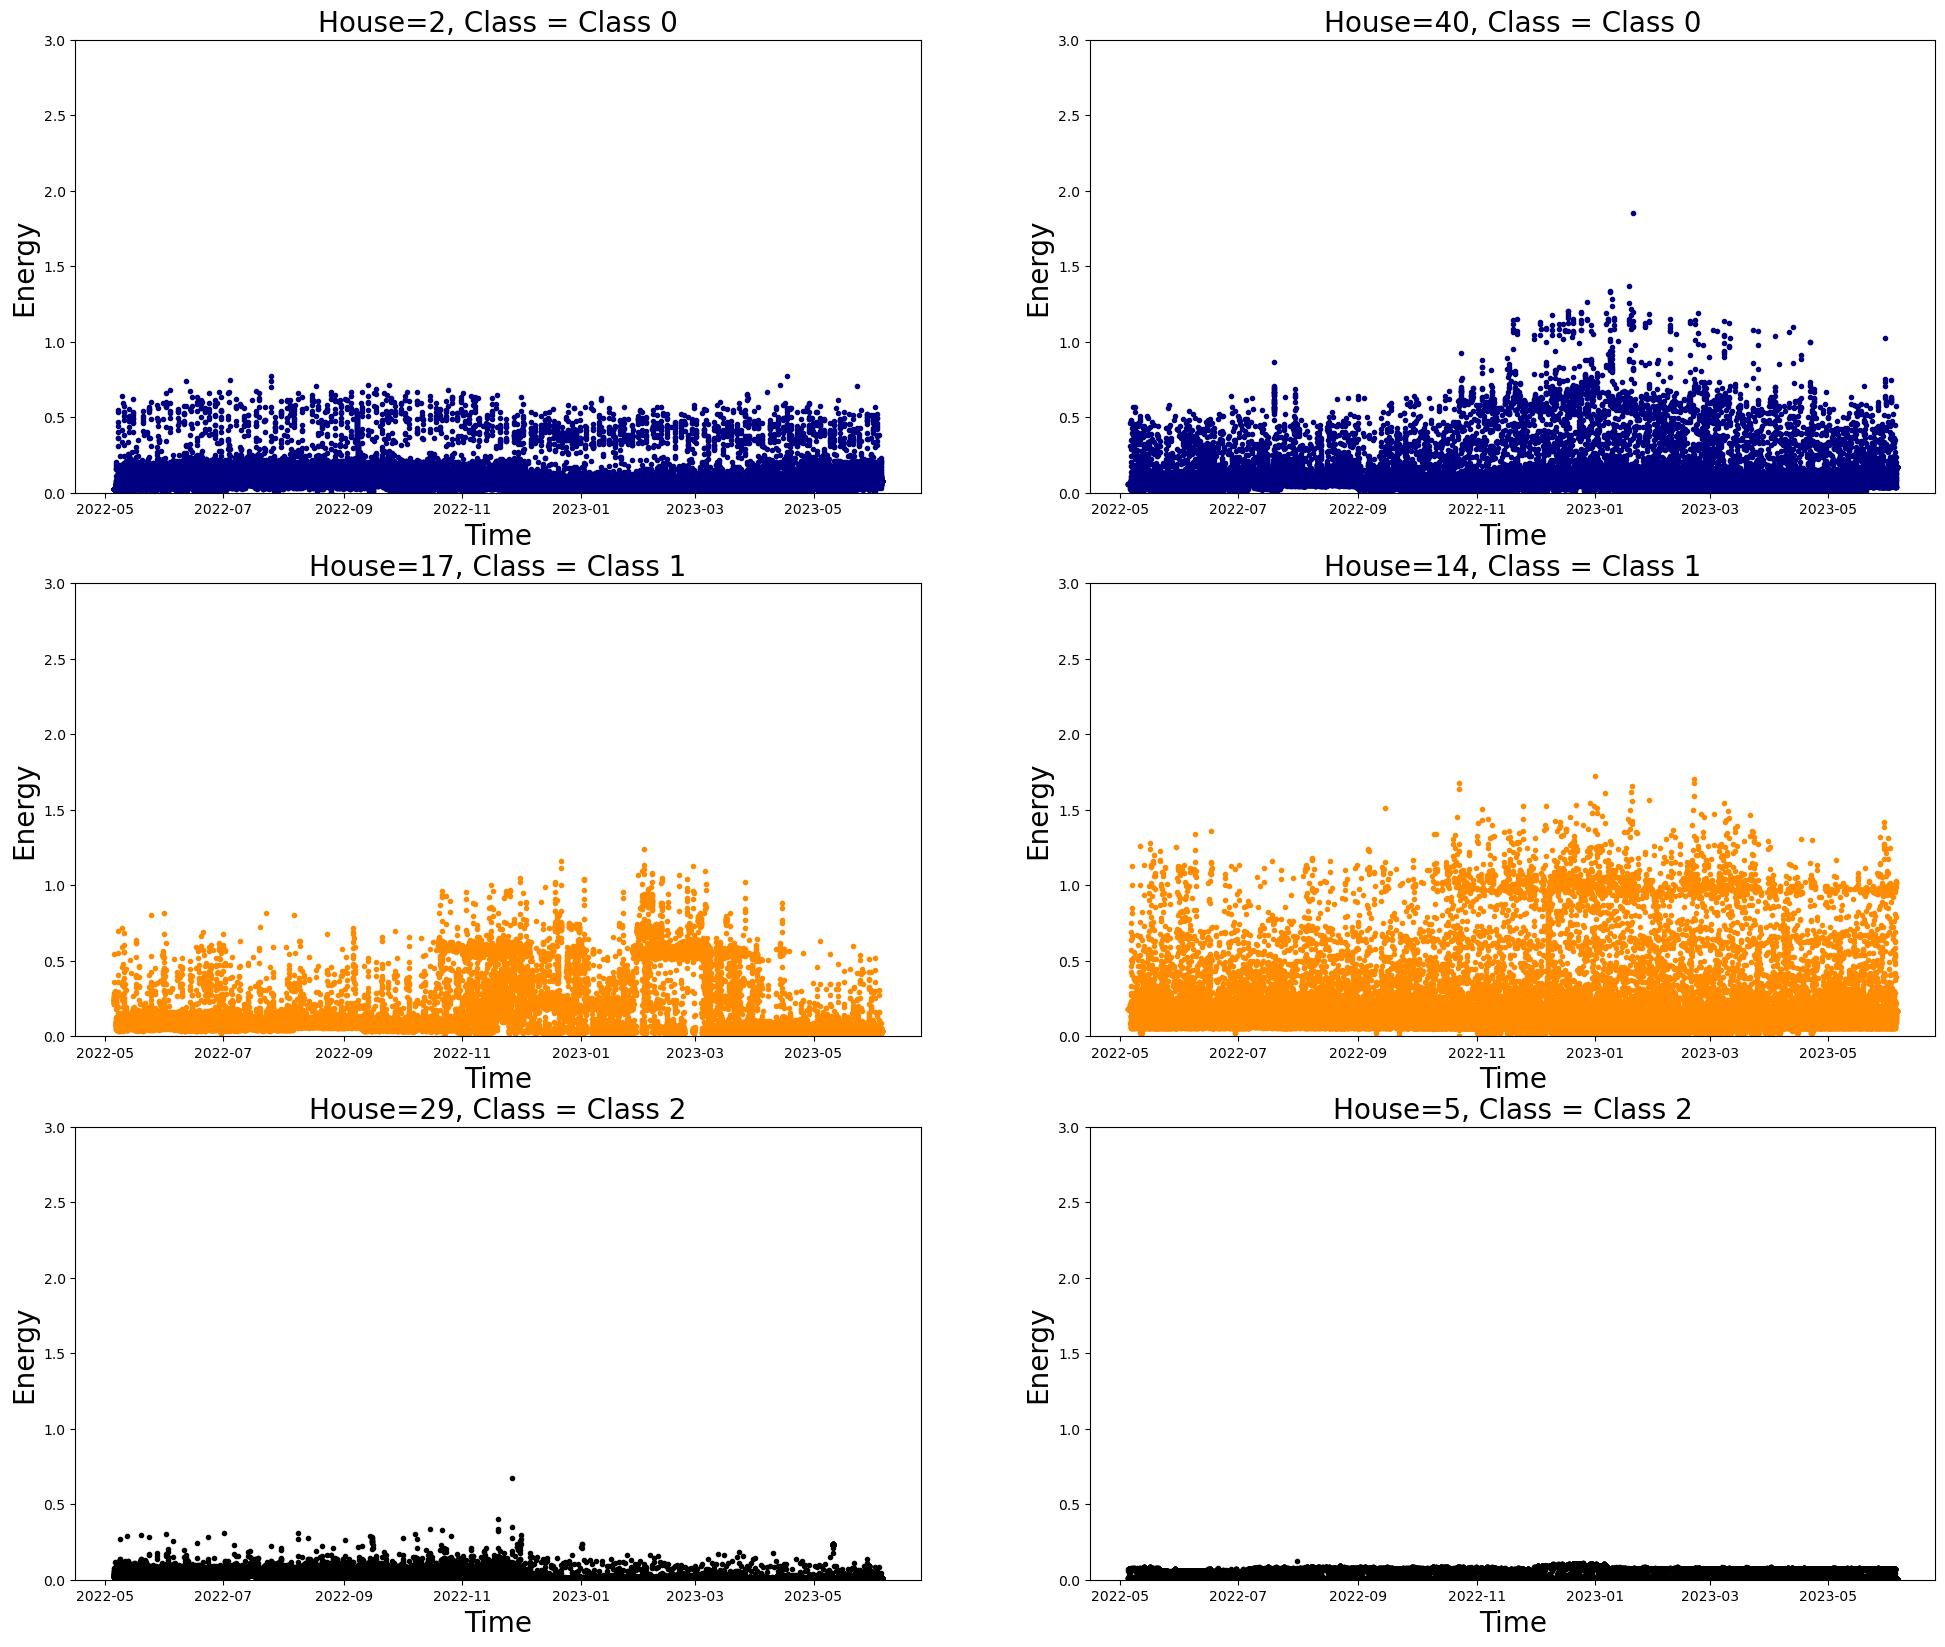

In [34]:
plt.figure(figsize=(24,20))
k_dict = {'1':3,'2':3,'3':1,'4':1,'5':2,'6':2}
colors = ['navy']*2+['darkorange']*2+['k']*2
Names = ['Class 0']*2+['Class 1']*2+['Class 2']*2
for j in range(1,7):
    plt.subplot(3,2,j)
    k = np.random.choice(np.where(y==k_dict[str(j)])[0])
    plt.plot(df.Time,df["{}".format(df.drop('Time', axis=1).columns[k])],'.',color=colors[j-1])
    plt.ylabel('Energy',fontsize=20)
    plt.xlabel('Time',fontsize=20)
    plt.title('House=%s, Class = %s'%(cities_list[k],Names[j-1]),fontsize=20)
    plt.ylim(0,3)

In [ ]:
cluster_list = []
for i in range(0,n_clusters):
    cluster_list.append(np.where(y == i)[0])
len(cluster_list)

In [ ]:
string = "cluster"
for i in range(len(cluster_list)):
    st = string + str(i)
    locals()[st] = cluster_list[i]
    print(cluster_list[i])

In [ ]:
cluster0

In [ ]:
#cluster0.to_csv("data/.csv", index=None)

In [ ]:
#cluster2.to_csv("data/.csv", index=None)

In [ ]:
## Compare gains of cluster with normal runs